In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt

print("TF version:", tf.__version__)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TF version: 2.19.0


In [2]:
from pathlib import Path



PROJECT_ROOT = Path("/content/drive/MyDrive/plant_disease_project")


ZIP_PATH = PROJECT_ROOT / "Plant_leaf_diseases_dataset_with_augmentation.zip"
print("ZIP_PATH:", ZIP_PATH)


!unzip -q "{ZIP_PATH}" -d "{PROJECT_ROOT}"

print("Contents of project folder after unzip:")
for p in PROJECT_ROOT.iterdir():
    print(" -", p.name)


candidates = [p for p in PROJECT_ROOT.iterdir()
              if p.is_dir() and "leaf" in p.name.lower() and "augment" in p.name.lower()]

if len(candidates) == 1:
    DATA_DIR = candidates[0]
    print("\nDetected dataset folder:", DATA_DIR)
else:
    print("\n⚠️ Could not uniquely detect dataset folder. "
          "Set DATA_DIR manually to the correct folder name, e.g.:")
    print('DATA_DIR = PROJECT_ROOT / "Plant_leaf_diseases_dataset_with_augmentation"')


ZIP_PATH: /content/drive/MyDrive/plant_disease_project/Plant_leaf_diseases_dataset_with_augmentation.zip
Contents of project folder after unzip:
 - Plant_leaf_diseases_dataset_with_augmentation.zip
 - Plant_leaf_diseases_dataset_without_augmentation.zip
 - Plant_leaf_diseases_dataset_without_augmentation
 - resnet50_best.h5
 - resnet50_history.pkl
 - resnet50_classification_report.txt
 - Plant_leave_diseases_dataset_with_augmentation

Detected dataset folder: /content/drive/MyDrive/plant_disease_project/Plant_leaf_diseases_dataset_without_augmentation


In [2]:
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/plant_disease_project")

# ✅ Use the WITH-AUGMENTATION
DATA_DIR = PROJECT_ROOT / "Plant_leave_diseases_dataset_with_augmentation"

print("DATA_DIR:", DATA_DIR)
print("Subfolders under DATA_DIR (first 10):")
for p in list(DATA_DIR.glob("*"))[:10]:
    print(" -", p.name)


DATA_DIR: /content/drive/MyDrive/plant_disease_project/Plant_leave_diseases_dataset_with_augmentation
Subfolders under DATA_DIR (first 10):
 - Apple___Apple_scab
 - Apple___Black_rot
 - Apple___Cedar_apple_rust
 - Apple___healthy
 - Background_without_leaves
 - Blueberry___healthy
 - Cherry___healthy
 - Cherry___Powdery_mildew
 - Corn___Cercospora_leaf_spot Gray_leaf_spot
 - Corn___Common_rust


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16   # ✅ use 16 to avoid crashes
SEED = 42

TRAIN_COUNT = 10_000
VAL_COUNT   = 2_000
TEST_COUNT  = 2_000


In [7]:
def load_subset_from_directory(
    data_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    train_count=TRAIN_COUNT,
    val_count=VAL_COUNT,
    test_count=TEST_COUNT,
    seed=SEED,
):
    # 1) Load dataset with shuffling and batch size
    base_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
    )

    class_names = base_ds.class_names
    num_classes = len(class_names)
    print("Num classes:", num_classes)
    print("First few classes:", class_names[:10])

    # 2) Flatten to per-image elements
    full_ds = base_ds.unbatch()  # each element: (image, label)

    # 3) Attach indices to each element
    full_ds = full_ds.enumerate()  # (idx, (image, label))

    total_needed = train_count + val_count + test_count
    print("Taking first", total_needed, "examples as subset")

    # Helper to create slices by index range
    def in_range(start, end):
        return lambda idx, _: tf.logical_and(idx >= start, idx < end)

    train_range_end = train_count
    val_range_end   = train_count + val_count
    test_range_end  = train_count + val_count + test_count

    # 4) Filter ranges and drop the index
    train_ds = full_ds.filter(in_range(0, train_range_end)).map(lambda _, data: data)
    val_ds   = full_ds.filter(in_range(train_range_end, val_range_end)).map(lambda _, data: data)
    test_ds  = full_ds.filter(in_range(val_range_end, test_range_end)).map(lambda _, data: data)

    # 5) Re-batch and prefetch
    autotune = tf.data.AUTOTUNE

    train_ds = train_ds.batch(batch_size).prefetch(autotune)
    val_ds   = val_ds.batch(batch_size).prefetch(autotune)
    test_ds  = test_ds.batch(batch_size).prefetch(autotune)

    return train_ds, val_ds, test_ds, class_names

train_ds, val_ds, test_ds, class_names = load_subset_from_directory(DATA_DIR)


Found 61486 files belonging to 39 classes.
Num classes: 39
First few classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust']
Taking first 14000 examples as subset


In [8]:
sample_batch = next(iter(train_ds))
images, labels = sample_batch

print("images shape:", images.shape)
print("labels shape:", labels.shape)


images shape: (16, 224, 224, 3)
labels shape: (16,)


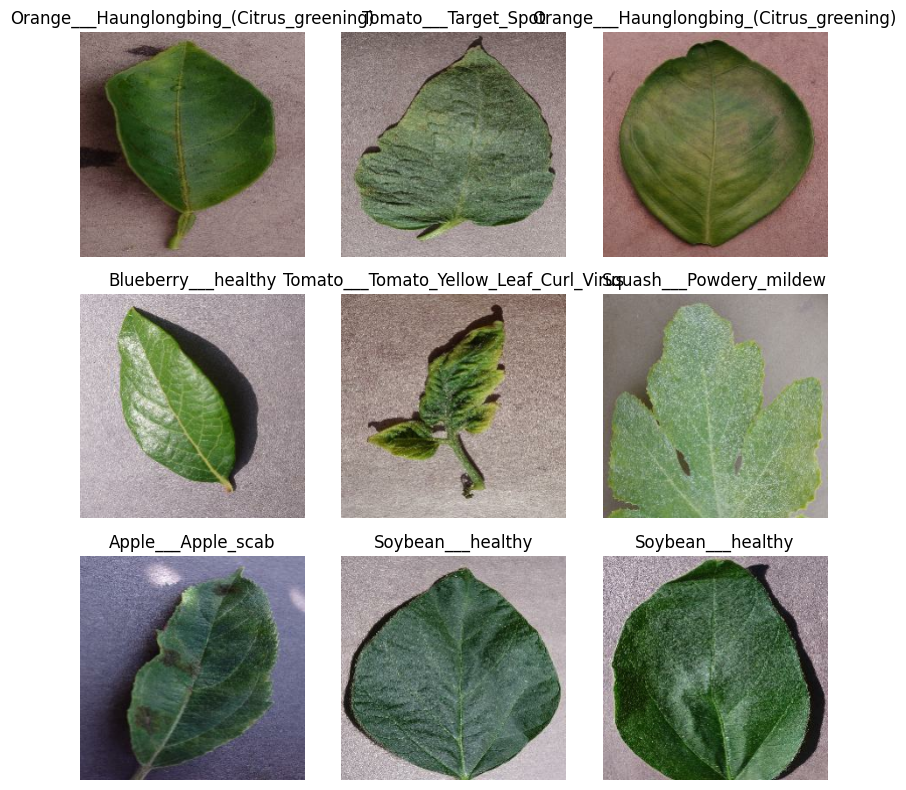

In [9]:
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Number of classes from dataset
num_classes = len(class_names)
input_shape = IMG_SIZE + (3,)

# Data augmentation inside the model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

# Input layer
inputs = layers.Input(shape=input_shape, name="input_image")

# Apply augmentation
x = data_augmentation(inputs)

# Preprocess for ResNet50 (ImageNet-style normalization)
x = preprocess_input(x)

# Base ResNet50 model (pretrained, no top)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

# Freeze base model
base_model.trainable = False

# Global pooling + dropout + classifier
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(base_model.output)
x = layers.Dropout(0.5, name="dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = Model(inputs, outputs, name="ResNet50_leaf_subset")

model.summary()


Model: "ResNet50_leaf_subset"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add_1[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,667,623 (90.28 MB)

 Trainable params: 79,911 (312.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
CHECKPOINT_PATH = str(PROJECT_ROOT / "resnet50_subset_best.weights.h5")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True
)

EPOCHS = 12

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/12
    625/Unknown 51s 82ms/step - accuracy: 0.8811 - loss: 0.3909

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 464s 744ms/step - accuracy: 0.8811 - loss: 0.3908 - val_accuracy: 0.9165 - val_loss: 0.2657
Epoch 2/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 732ms/step - accuracy: 0.9138 - loss: 0.2830 - val_accuracy: 0.9275 - val_loss: 0.2286
Epoch 3/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 455s 729ms/step - accuracy: 0.9291 - loss: 0.2306 - val_accuracy: 0.9305 - val_loss: 0.2062
Epoch 4/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 732ms/step - accuracy: 0.9325 - loss: 0.2171 - val_accuracy: 0.9405 - val_loss: 0.1900
Epoch 5/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 732ms/step - accuracy: 0.9387 - loss: 0.1938 - val_accuracy: 0.9330 - val_loss: 0.1957
Epoch 6/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 457s 732ms/step - accuracy: 0.9418 - loss: 0.1820 - val_accuracy: 0.9440 - val_loss: 0.1696
Epoch 7/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 453s 726ms/step - accuracy: 0.9419 - loss: 0.1730 - val_accuracy: 0.9330 - val_loss: 0.1920
Epoch 8/12
625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 704ms/step - accuracy: 0.9485 - loss: 0.16

In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9634 - loss: 0.1092
Test loss: 0.1241
Test accuracy: 0.9595


In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt


In [19]:
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [20]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print(report)

# Save to Drive
report_path = PROJECT_ROOT / "resnet50_subset_classification_report.txt"
with open(report_path, "w") as f:
    f.write(report)

print("Saved classification report to:", report_path)


                                               precision    recall  f1-score   support

                           Apple___Apple_scab     0.9714    0.9714    0.9714        35
                            Apple___Black_rot     1.0000    0.9630    0.9811        27
                     Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        43
                              Apple___healthy     0.9167    0.9851    0.9496        67
                    Background_without_leaves     1.0000    1.0000    1.0000        42
                          Blueberry___healthy     0.9821    1.0000    0.9910        55
                      Cherry___Powdery_mildew     1.0000    0.9762    0.9880        42
                             Cherry___healthy     1.0000    0.9535    0.9762        43
   Corn___Cercospora_leaf_spot Gray_leaf_spot     0.9600    0.8889    0.9231        27
                           Corn___Common_rust     1.0000    0.9677    0.9836        31
                  Corn___Northern_Leaf_Bli

Saved confusion matrix to: /content/drive/MyDrive/plant_disease_project/resnet50_subset_confusion_matrix.png


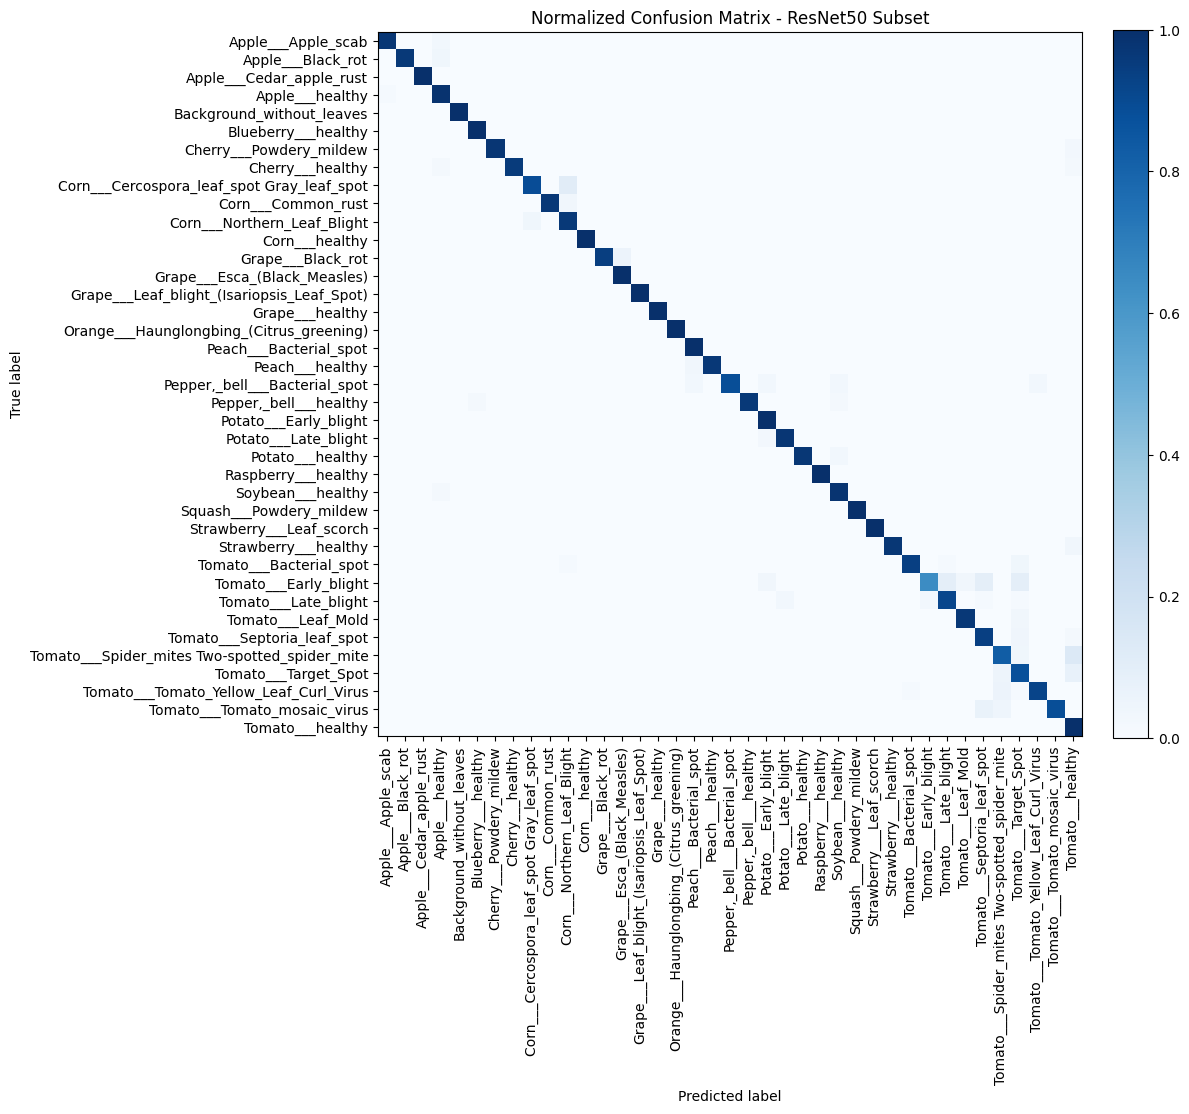

In [21]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")
plt.title("Normalized Confusion Matrix - ResNet50 Subset")
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names)

ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

plt.tight_layout()

cm_path = PROJECT_ROOT / "resnet50_subset_confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print("Saved confusion matrix to:", cm_path)
plt.show()


Saved F1 bar chart to: /content/drive/MyDrive/plant_disease_project/resnet50_subset_f1_scores.png


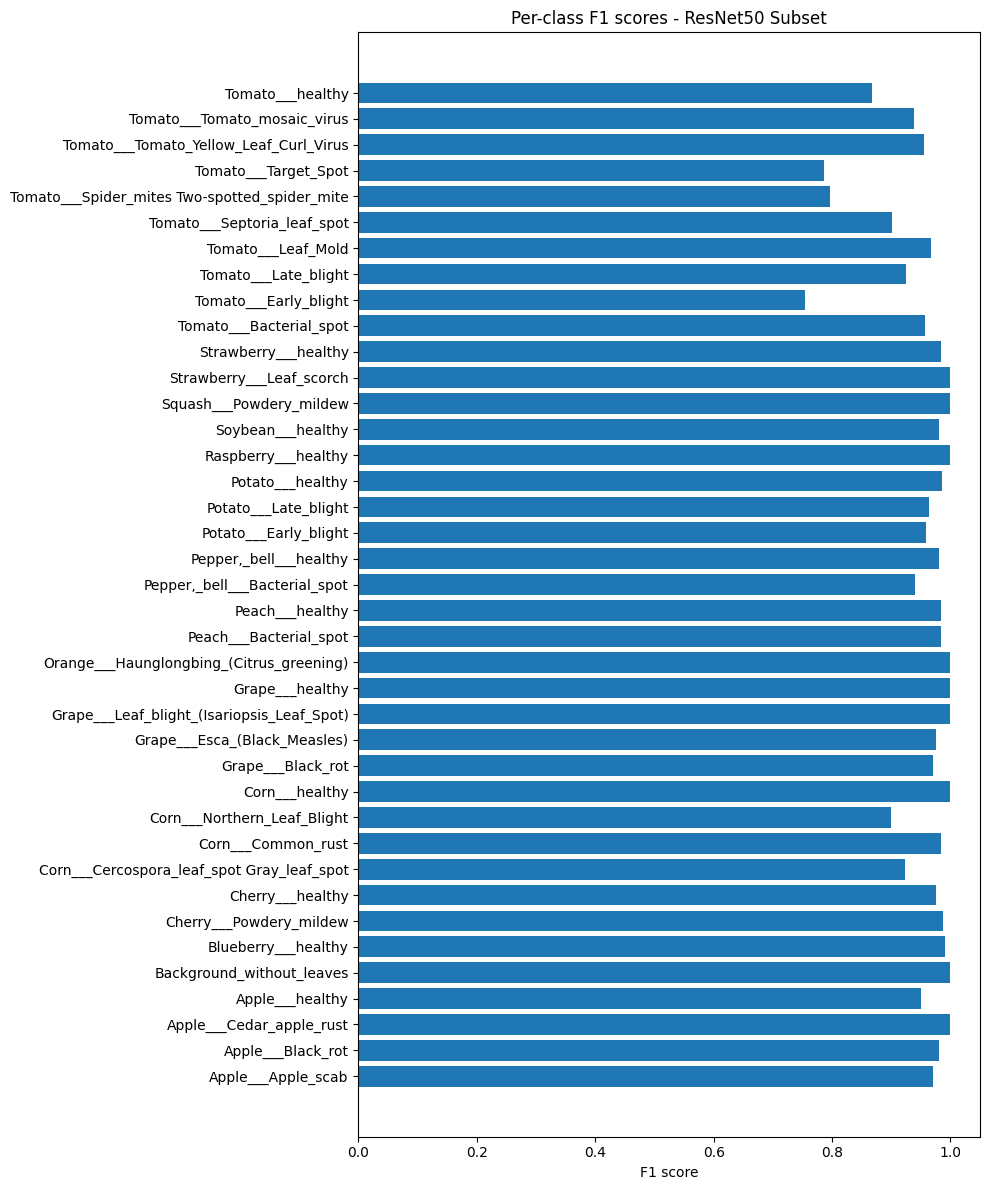

In [22]:
f1_per_class = f1_score(y_true, y_pred, average=None)

plt.figure(figsize=(10, 12))
y_pos = np.arange(len(class_names))

plt.barh(y_pos, f1_per_class)
plt.yticks(y_pos, class_names)
plt.xlabel("F1 score")
plt.title("Per-class F1 scores - ResNet50 Subset")

plt.tight_layout()

f1_path = PROJECT_ROOT / "resnet50_subset_f1_scores.png"
plt.savefig(f1_path, dpi=300, bbox_inches="tight")
print("Saved F1 bar chart to:", f1_path)
plt.show()


Saved accuracy curve to: /content/drive/MyDrive/plant_disease_project/resnet50_subset_accuracy.png


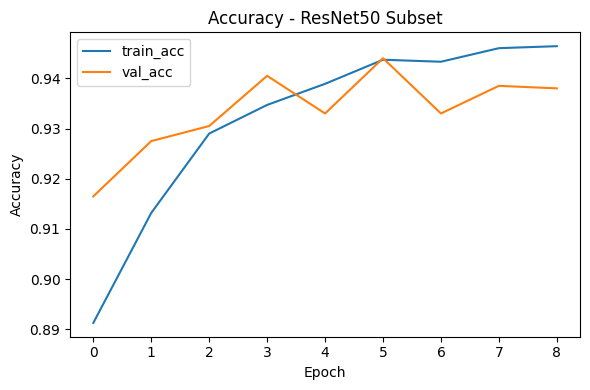

Saved loss curve to: /content/drive/MyDrive/plant_disease_project/resnet50_subset_loss.png


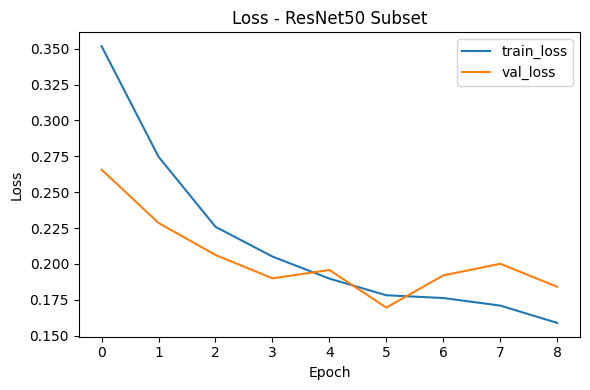

In [23]:
# Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy - ResNet50 Subset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

acc_path = PROJECT_ROOT / "resnet50_subset_accuracy.png"
plt.savefig(acc_path, dpi=300, bbox_inches="tight")
print("Saved accuracy curve to:", acc_path)
plt.show()

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss - ResNet50 Subset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

loss_path = PROJECT_ROOT / "resnet50_subset_loss.png"
plt.savefig(loss_path, dpi=300, bbox_inches="tight")
print("Saved loss curve to:", loss_path)
plt.show()
